In [31]:
import numpy as np
import torch
from datasets.mnist1d import load_MNIST1D
from datasets.control import get_mixture_distribution, load_control
import os
import matplotlib.pyplot as plt

In [32]:
mixture_list = [
    # uniform between [-10, -5] and [5, 10] (for 2D data)
    ("uniform",
     np.array([-10.0, -5.0, -10, -10]),
     np.array([5.0, 10.0, -5, 5])),

    # normal with mean [10, 5, -5] and std [2, 12, 1]
    ("normal",
     np.array([10.0,  5.0, -5.0, -5]),
     np.array([ 2.0, 12.0,  1.0, 1])),

    # normal centered at 0 with unit variance in all dims
    ("normal",
     np.array([0.0, 0.0, 0.0, 0]),
     np.array([1.0, 1.0, 1.0, 1])),

    # normal with mean [3, 6, 2] and std [4, 5, 3]
    ("normal",
     np.array([3.0, 6.0, 2.0, 2]),
     np.array([4.0, 5.0, 3.0, 3])),

    # laplace centered at [4, 4, 4] with scale 1
    ("laplace",
     np.array([4.0, 4.0, 4.0, 4]),
     np.array([1.0, 1.0, 1.0, 1])),

    # normal centered at -5 with std 3 in all dims
    ("normal",
     np.array([-5.0, -5.0, -5.0, -5]),
     np.array([3.0, 3.0, 3.0, 3])),

    # exponential with scale=1 in all dims, then shifted by -5
    ("exponential",
     np.array([1.0, 1.0, 1.0, 1]),    # scale
     np.array([-5.0, -5.0, -5.0, -5])), # shift
]


# mixture_list = [
#     ('uniform', np.array([-10.,  -5.]), np.array([ 5., 10.])),
#     ('normal', np.array([10.,  5.]), np.array([ 2., 12.])),
#     ('normal', np.array([0., 0.]), np.array([1., 1.])),
#     ('normal', np.array([3., 6.]), np.array([4., 5.])),
#     ('laplace', np.array([4., 4.]), np.array([1., 1.])),
#     ('normal', np.array([-5., -5.]), np.array([3., 3.])),
#     ('exponential', np.array([1., 1.]), np.array([-5., -5.]))
# ]

# mixture_list = [
#     ('normal', np.array([0., 0.]), np.array([1., 1.])),
# ]

weights = [0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0.1]
# weights = [1]
control_data = get_mixture_distribution(mixture_list, weights, size=(10000, 4))

# Train GMMN

## Parameters

In [34]:
model_dir = "./model_weights"

BATCH_SIZE = 1000 # taken from original paper
# trainloader, testloader, min_value, max_value = load_MNIST1D(batch_size = BATCH_SIZE)
# trainloader, testloader = load_MNIST(batch_size = BATCH_SIZE, size=7, flatten=True)
trainloader, testloader, min_value, max_value = load_control(control_data, batch_size=1000)
for batch_inputs, batch_targets in trainloader:
    # Do training step here
    print(batch_inputs.shape, batch_targets.shape)
    break
N_INP = next(iter(trainloader))[0].shape[1]
NOISE_SIZE = 10
ENCODED_SIZE = 10
N_ENCODER_EPOCHS = 2000
N_GEN_EPOCHS = 200

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1000, 4]) torch.Size([1000, 4])


## Train Autoencoder


Autoencoder Training Progress: 100%|██████████| 2000/2000 [05:31<00:00,  6.03it/s]


Autoencoder has been successfully trained


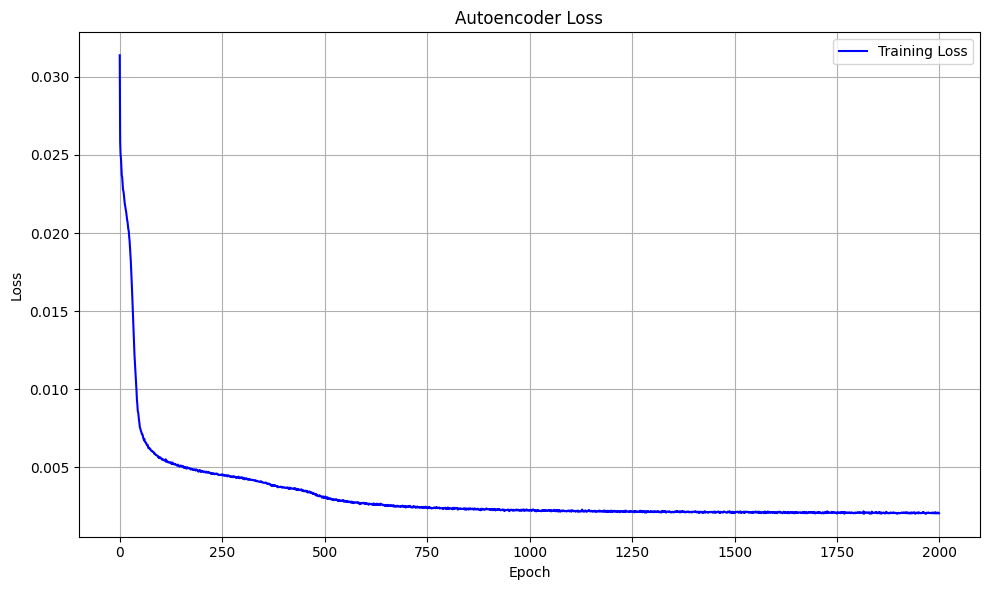

In [35]:
from models.gmmn.train_autoencoder import train_autoencoder
from visualization.loss import plot_loss

ENCODER_SAVE_PATH = model_dir + "/autoencoder_control-presentation.pth"
autoencoder, losses_autoencoder = train_autoencoder(trainloader, N_INP, ENCODED_SIZE, N_ENCODER_EPOCHS, device, ENCODER_SAVE_PATH)
plot_loss(losses_autoencoder, title="Autoencoder Loss")

## Continue with GMMN


GMMN Training Progress: 100%|██████████| 200/200 [09:26<00:00,  2.83s/it, Avg Loss=0.0004, Epoch=200/200]


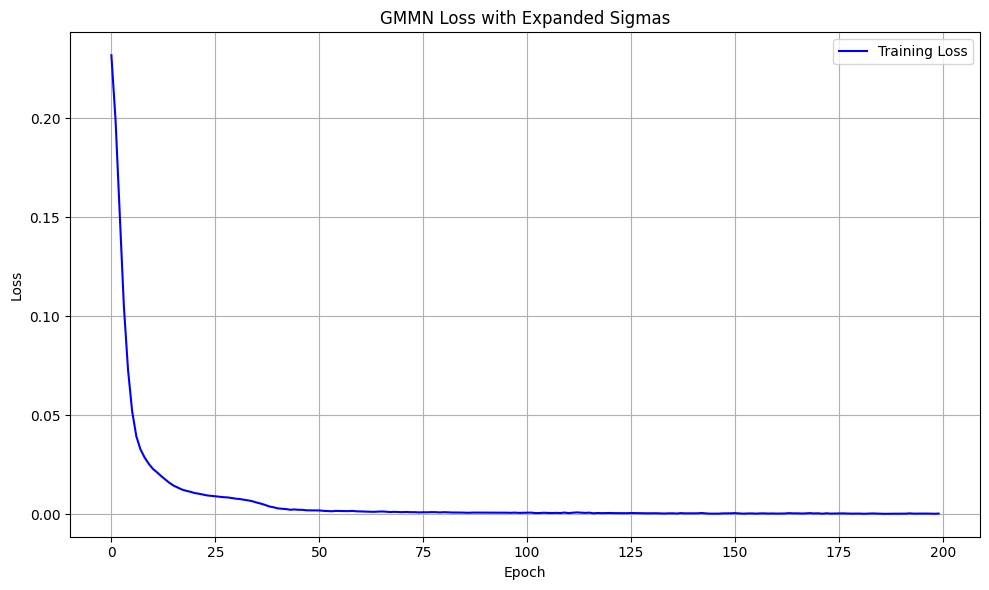

In [36]:
from models.gmmn.train_gmmn import train_gmmn
sigmas = [0.01, 0.1, 0.5,  1, 2,  5, 10, 20, 50]
GMMN_SAVE_PATH = model_dir + "/gmmn_standard_normal_expanded_sigmas.pth"


gmm_net, losses_gmmn = train_gmmn(
    trainloader, autoencoder, sigmas, ENCODED_SIZE, NOISE_SIZE, BATCH_SIZE, N_GEN_EPOCHS, device, GMMN_SAVE_PATH
)

plot_loss(losses_gmmn, title="GMMN Loss with Expanded Sigmas")

Using device: cpu
Starting training...


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:  10%|▉         | 48/500 [01:36<14:48,  1.97s/it]

[48/500][66/125] Iter: 500 Loss_D: -0.042627 Loss_G: -0.000241 |gD|: 1.3276e+01 |gG|: 6.0102e-04 Time(min): 1.62


Training Epochs:  10%|▉         | 49/500 [01:38<15:11,  2.02s/it]

[48/500][125/125] Iter: 500 Loss_D: -0.060010 Loss_G: -0.000241 |gD|: 1.6545e+01 |gG|: 6.0102e-04 Time(min): 1.64


Training Epochs:  15%|█▍        | 74/500 [02:44<31:37,  4.45s/it]

[74/500][90/125] Iter: 1000 Loss_D: -0.039419 Loss_G: -0.000223 |gD|: 1.1301e+01 |gG|: 6.1016e-04 Time(min): 2.84


Training Epochs:  15%|█▌        | 75/500 [02:54<43:17,  6.11s/it]

[74/500][125/125] Iter: 1000 Loss_D: -0.051413 Loss_G: -0.000223 |gD|: 1.4189e+01 |gG|: 6.1016e-04 Time(min): 2.91


Training Epochs:  20%|██        | 100/500 [04:49<17:55,  2.69s/it] 

[100/500][90/125] Iter: 1500 Loss_D: -0.031635 Loss_G: -0.000163 |gD|: 1.1501e+01 |gG|: 5.0264e-04 Time(min): 4.86


Training Epochs:  20%|██        | 101/500 [04:52<18:33,  2.79s/it]

[100/500][125/125] Iter: 1500 Loss_D: -0.033176 Loss_G: -0.000163 |gD|: 1.6774e+01 |gG|: 5.0264e-04 Time(min): 4.87


Training Epochs:  25%|██▌       | 126/500 [05:47<12:43,  2.04s/it]

[126/500][90/125] Iter: 2000 Loss_D: -0.017167 Loss_G: -0.000156 |gD|: 7.7729e+00 |gG|: 5.1937e-04 Time(min): 5.83


Training Epochs:  25%|██▌       | 127/500 [05:50<13:41,  2.20s/it]

[126/500][125/125] Iter: 2000 Loss_D: -0.045223 Loss_G: -0.000156 |gD|: 1.6848e+01 |gG|: 5.1937e-04 Time(min): 5.84


Training Epochs:  30%|███       | 152/500 [06:49<13:11,  2.27s/it]

[152/500][90/125] Iter: 2500 Loss_D: -0.020849 Loss_G: -0.000139 |gD|: 7.2465e+00 |gG|: 5.9435e-04 Time(min): 6.85


Training Epochs:  31%|███       | 153/500 [06:52<14:29,  2.50s/it]

[152/500][125/125] Iter: 2500 Loss_D: -0.015895 Loss_G: -0.000139 |gD|: 9.5641e+00 |gG|: 5.9435e-04 Time(min): 6.87


Training Epochs:  36%|███▌      | 178/500 [07:55<09:54,  1.85s/it]

[178/500][90/125] Iter: 3000 Loss_D: -0.173589 Loss_G: -0.000125 |gD|: 8.8278e+01 |gG|: 4.2966e-04 Time(min): 7.96


Training Epochs:  36%|███▌      | 179/500 [07:58<11:37,  2.17s/it]

[178/500][125/125] Iter: 3000 Loss_D: -0.014636 Loss_G: -0.000125 |gD|: 5.1279e+00 |gG|: 4.2966e-04 Time(min): 7.97


Training Epochs:  41%|████      | 204/500 [08:45<08:11,  1.66s/it]

[204/500][90/125] Iter: 3500 Loss_D: -0.012572 Loss_G: -0.000115 |gD|: 6.2372e+00 |gG|: 5.8918e-04 Time(min): 8.77


Training Epochs:  41%|████      | 205/500 [08:46<08:10,  1.66s/it]

[204/500][125/125] Iter: 3500 Loss_D: -0.013903 Loss_G: -0.000115 |gD|: 7.4266e+00 |gG|: 5.8918e-04 Time(min): 8.78


Training Epochs:  46%|████▌     | 230/500 [09:26<05:24,  1.20s/it]

[230/500][90/125] Iter: 4000 Loss_D: -0.010557 Loss_G: -0.000099 |gD|: 1.0492e+01 |gG|: 3.7854e-04 Time(min): 9.45


Training Epochs:  46%|████▌     | 231/500 [09:27<05:43,  1.28s/it]

[230/500][125/125] Iter: 4000 Loss_D: -0.012576 Loss_G: -0.000099 |gD|: 5.8754e+00 |gG|: 3.7854e-04 Time(min): 9.47


Training Epochs:  51%|█████     | 256/500 [10:10<07:24,  1.82s/it]

[256/500][90/125] Iter: 4500 Loss_D: -0.008644 Loss_G: -0.000109 |gD|: 6.0141e+00 |gG|: 3.5809e-04 Time(min): 10.19


Training Epochs:  51%|█████▏    | 257/500 [10:12<07:02,  1.74s/it]

[256/500][125/125] Iter: 4500 Loss_D: -0.010273 Loss_G: -0.000109 |gD|: 6.0985e+00 |gG|: 3.5809e-04 Time(min): 10.20


Training Epochs:  56%|█████▋    | 282/500 [10:52<06:04,  1.67s/it]

[282/500][90/125] Iter: 5000 Loss_D: -0.009519 Loss_G: -0.000069 |gD|: 6.5126e+00 |gG|: 3.6320e-04 Time(min): 10.90


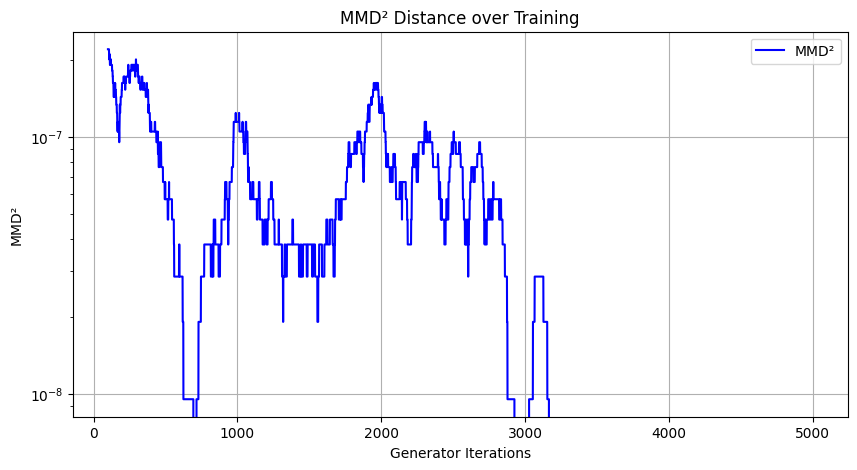

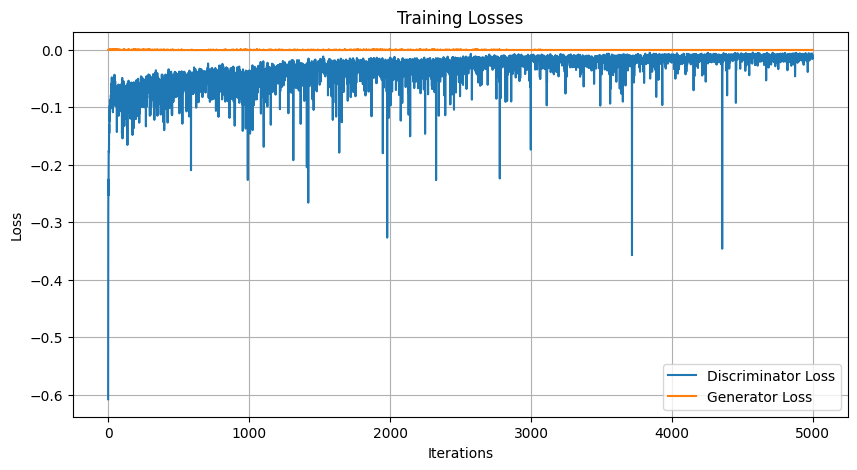

[282/500][125/125] Iter: 5000 Loss_D: -0.016392 Loss_G: -0.000069 |gD|: 6.1110e+00 |gG|: 3.6320e-04 Time(min): 10.94


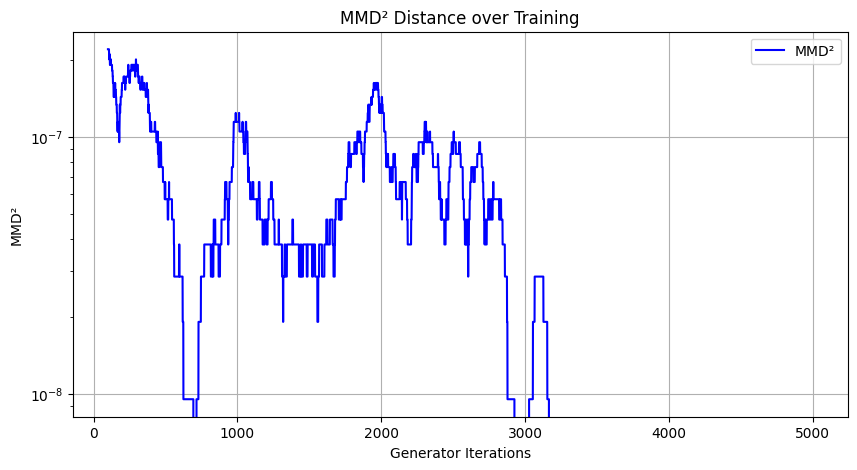

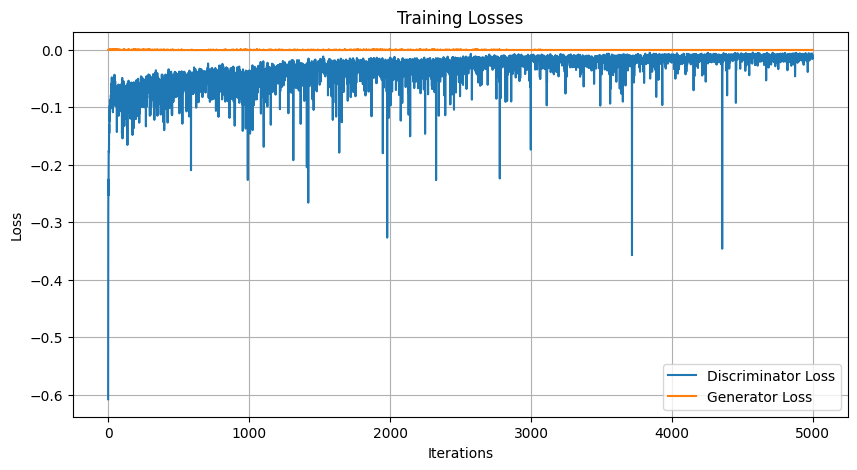

Training Epochs:  62%|██████▏   | 308/500 [12:14<12:20,  3.86s/it]

[308/500][90/125] Iter: 5500 Loss_D: -0.031662 Loss_G: -0.000073 |gD|: 2.0094e+01 |gG|: 2.4725e-04 Time(min): 12.27


Training Epochs:  62%|██████▏   | 309/500 [12:16<10:32,  3.31s/it]

[308/500][125/125] Iter: 5500 Loss_D: -0.019667 Loss_G: -0.000073 |gD|: 1.3373e+01 |gG|: 2.4725e-04 Time(min): 12.28


Training Epochs:  67%|██████▋   | 334/500 [13:41<10:08,  3.67s/it]

[334/500][90/125] Iter: 6000 Loss_D: -0.010469 Loss_G: -0.000069 |gD|: 6.6526e+00 |gG|: 2.2448e-04 Time(min): 13.72


Training Epochs:  67%|██████▋   | 335/500 [13:44<09:26,  3.43s/it]

[334/500][125/125] Iter: 6000 Loss_D: -0.008004 Loss_G: -0.000069 |gD|: 6.2551e+00 |gG|: 2.2448e-04 Time(min): 13.74


Training Epochs:  72%|███████▏  | 360/500 [15:03<08:07,  3.48s/it]

[360/500][90/125] Iter: 6500 Loss_D: -0.013764 Loss_G: -0.000065 |gD|: 9.9195e+00 |gG|: 3.5224e-04 Time(min): 15.11


Training Epochs:  72%|███████▏  | 361/500 [15:08<09:15,  4.00s/it]

[360/500][125/125] Iter: 6500 Loss_D: -0.014533 Loss_G: -0.000065 |gD|: 8.4408e+00 |gG|: 3.5224e-04 Time(min): 15.14


Training Epochs:  77%|███████▋  | 386/500 [16:10<04:17,  2.25s/it]

[386/500][90/125] Iter: 7000 Loss_D: -0.008335 Loss_G: -0.000069 |gD|: 6.7585e+00 |gG|: 1.4794e-04 Time(min): 16.19


Training Epochs:  77%|███████▋  | 387/500 [16:12<04:03,  2.16s/it]

[386/500][125/125] Iter: 7000 Loss_D: -0.008537 Loss_G: -0.000069 |gD|: 6.5786e+00 |gG|: 1.4794e-04 Time(min): 16.21


Training Epochs:  82%|████████▏ | 412/500 [17:01<03:05,  2.11s/it]

[412/500][90/125] Iter: 7500 Loss_D: -0.018126 Loss_G: -0.000081 |gD|: 9.4209e+00 |gG|: 2.4627e-04 Time(min): 17.05


Training Epochs:  83%|████████▎ | 413/500 [17:03<02:53,  1.99s/it]

[412/500][125/125] Iter: 7500 Loss_D: -0.008234 Loss_G: -0.000081 |gD|: 4.6762e+00 |gG|: 2.4627e-04 Time(min): 17.06


Training Epochs:  88%|████████▊ | 438/500 [17:57<02:25,  2.35s/it]

[438/500][90/125] Iter: 8000 Loss_D: -0.009765 Loss_G: -0.000060 |gD|: 5.7512e+00 |gG|: 1.0122e-04 Time(min): 18.00


Training Epochs:  88%|████████▊ | 439/500 [18:00<02:32,  2.51s/it]

[438/500][125/125] Iter: 8000 Loss_D: -0.007518 Loss_G: -0.000060 |gD|: 3.1741e+00 |gG|: 1.0122e-04 Time(min): 18.01


Training Epochs:  91%|█████████▏| 457/500 [19:38<05:02,  7.04s/it]

In [ ]:
from models.mmd_gan_non_image.train_mmd_gan_non_image import train_mmd_gan_vector 
# 
MMD_GAN_SAVE_PATH = model_dir + "/mmd_gan_control_multivariate_gaussian.pth"
%matplotlib inline
trainloader, testloader, min_value, max_value = load_control(control_data, batch_size=64)
# netG, netD, losses_D, losses_G, mmd2_values, iterations = train_mmd_gan_vector(trainloader, N_INP, latent_dim=NOISE_SIZE, max_iter=100, batch_size = 64, experiment_name="control_presentation", sigma_list=sigmas)
netG, netD, losses_D, losses_G, mmd2_values, iterations = train_mmd_gan_vector(trainloader, N_INP, latent_dim=50, hidden_dims_enc=[256, 128], hidden_dims_dec=[128, 256], batch_size=64, max_iter=500, experiment_name='mmdgan_experiment', sigma_list=sigmas)

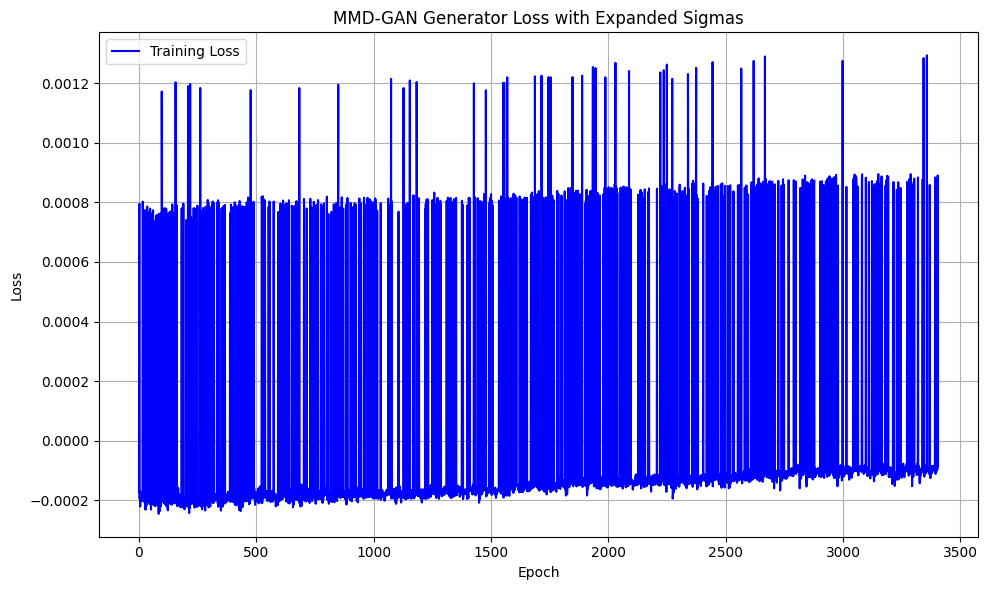

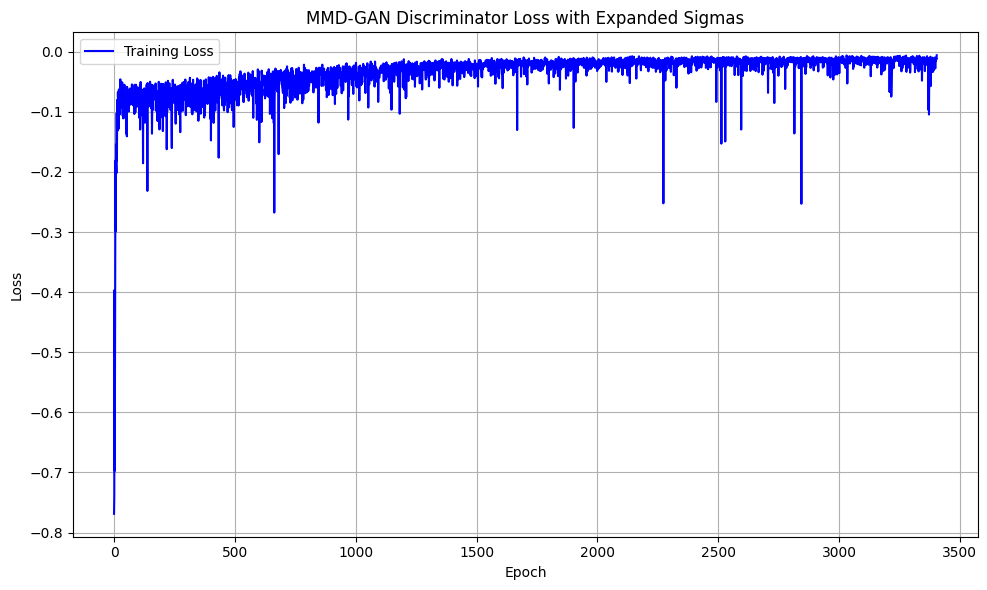

In [51]:
plot_loss(losses_G, title="MMD-GAN Generator Loss with Expanded Sigmas")
plot_loss(losses_D, title="MMD-GAN Discriminator Loss with Expanded Sigmas")

## Sample Visualizations

##### MNIST 1-D
**Run only if data used is MNIST-1D**

In [ ]:
from visualization.visualize_1d_data import visualize_mnist1d
from models.gmmn.gmmn import generate_gmmn_samples

samples, labels = next(iter(trainloader))
visualize_mnist1d(samples, labels, title_prefix="Real")

In [ ]:
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10)
visualize_mnist1d(gen_samples, labels, title_prefix="Generated")

##### Control Data
**Work only if working with control data**

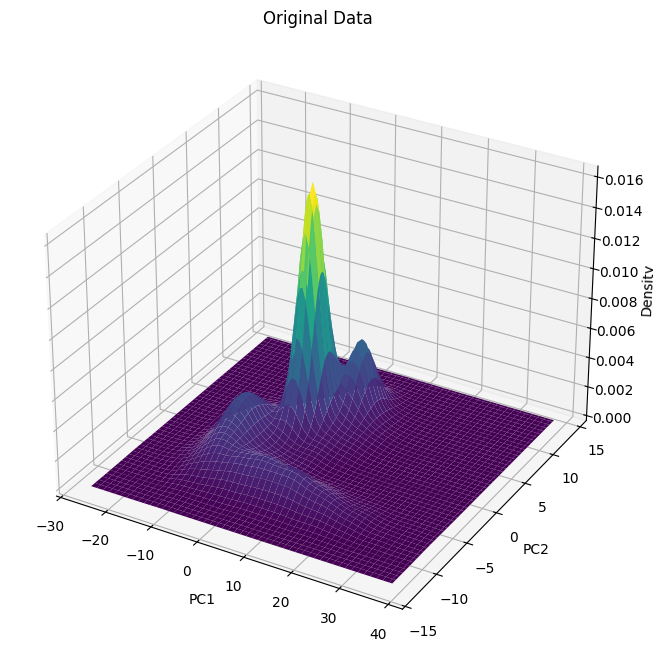

In [38]:
import visualization.plots
%matplotlib inline
visualization.plots.plot_3d_kde(control_data, "Original Data")

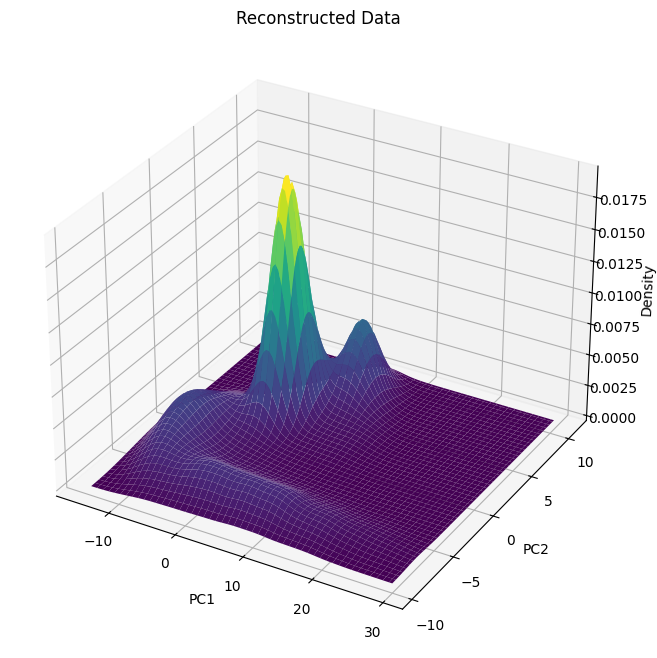

In [39]:
reconstructed_data = []
autoencoder.eval()
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(trainloader):
        reconstructed_data.append(autoencoder.forward(data)[1])

reconstructed_data = torch.cat(reconstructed_data, dim=0).numpy()
reconstructed_data = np.add(np.multiply(max_value - min_value, reconstructed_data), min_value)
visualization.plots.plot_3d_kde(reconstructed_data, "Reconstructed Data")

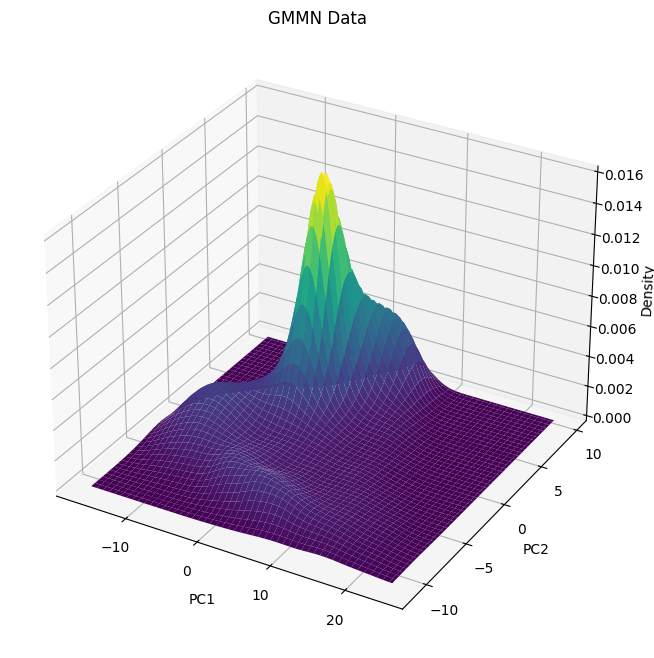

In [40]:
from models.gmmn.gmmn import generate_gmmn_samples
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10000)
gen_samples = np.add(np.multiply(max_value - min_value, gen_samples), min_value)
visualization.plots.plot_3d_kde(gen_samples, "GMMN Data")

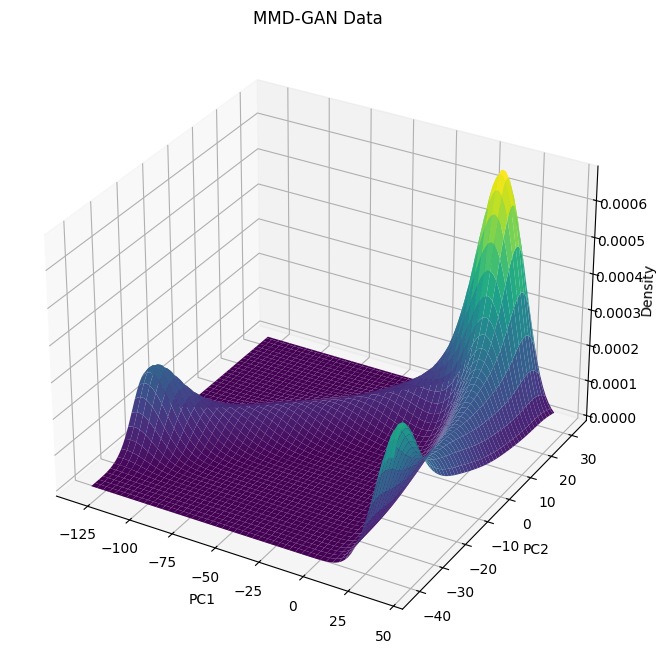

In [57]:
    
def generate_mmd_gan(model, NOISE_SIZE, number, device='cpu'):
    model.eval()
    model.to(device) 
    autoencoder.eval()

    generated_samples = []

    with torch.no_grad(): # Disable gradient calculations for inference
        for _ in range(number):
            noise = torch.randn((1, NOISE_SIZE)) 
            noise = noise.to(device) # Move noise to the same device as the model
            sample = model(noise)
            generated_samples.append(sample.cpu()) # Move generated sample to CPU for storage

    # Concatenate all generated samples into a single tensor
    return torch.squeeze(torch.cat(generated_samples, dim=0)).numpy()

gen_samples = generate_mmd_gan(netG, 100, 10000)
gen_samples = np.add(np.multiply(max_value - min_value, gen_samples), min_value)

visualization.plots.plot_3d_kde(gen_samples, "MMD-GAN Data")

## Bootstrapping Hypothesis Test

In [ ]:
from utilities.bootstrapping_test import bootstrap_hypothesis_test

original_data = []
for batch_idx, (data, labels) in enumerate(trainloader):
    original_data.append(data.cpu()) # .cpu() if data is on GPU
original_data = torch.cat(original_data, dim=0)
original_data = np.squeeze(original_data.numpy())
generating_function = generate_gmmn_samples
gen_args = (gmm_net, autoencoder, NOISE_SIZE, 20000)
alpha = 0.05
num_iterations = 1000

bootstrap_hypothesis_test(original_data, generating_function, gen_args, alpha, num_iterations)